# Chapter 24 - Asynchronous Initialization 


This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display asynchronous initiation of 30 RTM neurons. These RTM neurons are connected to one another via randomly selected synaptic weights. Each RTM neuron also has a variable external drive.

requirements:

 bmtk

 NEURON 7.4+

#### RTM Cell

$\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$

$\beta_{n} = 0.5*e^{-(v+57)/40}$

$\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$

$\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$

$\alpha_{h} = 0.128*e^{-(v+50)/18}$

$\beta_{h} = 4./(1+e^{-(v+27)/5})$

#### Creating 30 cell RTM network with variable synaptic weight connections

In [1]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =30

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Add excitatory connection from each RTM cell to every other RTM cell in the network and save

In [2]:
# add 1 synaptic connection from each cell to every other cell avoiding self connections
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0


def rand_syn_weight(source, target, min_weight, max_weight):
    sec_x=0.5
    sec_id=0
    return np.random.uniform(min_weight, max_weight), sec_x, sec_id


conn = net.add_edges(source={'pop_name': 'Exc'}, target={'pop_name': 'Exc'},
              connection_rule=one_each, # Note that we are passing in the function name but not calling it
              connection_params={},
              target_sections=['soma'],
              dynamics_params='PING_ExcToExc.json',     
              model_template='exp2syn',
              delay=0)

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.00625, 'max_weight': 0.00825},
                    dtypes=[np.float, np.uint, np.uint])

Build and save connections

In [3]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

### Create external network to asynchronously start each RTM neuron

In [4]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=30,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [5]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   connection_rule=one_each,
                   syn_weight=0.1,               
                   delay=0,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150],
                   dynamics_params='PING_ExcToExc.json',
                   model_template='exp2syn')

In [6]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

We now need to create an initial spike for each of our cells with varying phase

In [7]:
from bmtk.utils.reports.spike_trains import SpikeTrains

#create array of start times for heterogeneous initialization
start = np.random.rand(n_E,1)* 25 # array of 30 with times from 0 to 25

spikes = SpikeTrains(population='extnet')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=start[i])
spikes.to_sonata('input/Asynchronous.h5')

### External Drives

BMTK does not allow for multiple current clamps connecting to different cells. To approximate this feature, we will add a second external network that has variable synaptic weight connections to our RTM network.

In [8]:
n_In=30
drive = NetworkBuilder('drive')
drive.add_nodes(N=n_In,pop_name='Inp_drv',
            potential='inh',
            model_type='virtual')

In [9]:
conn = drive.add_edges(source={'pop_name':'Inp_drv'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    target_sections=['soma'],
                    distance_range=[0.0, 1.0],
                    dynamics_params='Drive.json',
                    model_template='expsyn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.02, 'max_weight': 0.025},
                    dtypes=[np.float, np.uint, np.uint])

In [10]:
drive.build()
drive.save_nodes(output_dir='network')
drive.save_edges(output_dir='network')

In [11]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='drive')
for i in range(30):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Drive.h5')

The RTM neurons also have a current clamp input that was defined earlier in our "frozen noise"

### Building the Simulation Environment

In [12]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=200.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                'input/Asynchronous.h5'), ('drive', 'input/Drive.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

### Running the Simulation

In [13]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-01-31 09:49:49,062 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-01-31 09:49:49,203 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-01-31 09:49:49,240 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-01-31 09:49:49,319 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2021-01-31 09:49:49,395 [INFO] Building virtual cell stimulations for drive_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for drive_spikes


2021-01-31 09:49:49,487 [INFO] Running simulation for 200.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 200.000 ms with the time step 0.100 ms


2021-01-31 09:49:49,507 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-01-31 09:49:49,538 [INFO] Block save every 2000 steps


INFO:NEURONIOUtils:Block save every 2000 steps


2021-01-31 09:49:50,555 [INFO]     step:2000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:2000 t_sim:200.00 ms


2021-01-31 09:49:50,599 [INFO] Simulation completed in 1.112 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.112 seconds 


## Displaying Results
A Spike raster is shown of our RTM network

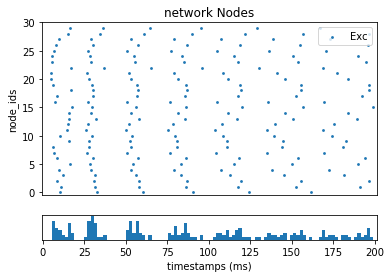

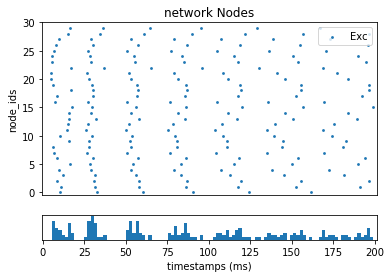

In [15]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='simulation_config.json', group_by='pop_name')

# If the plot does not show, run the cell again.

The two plots are the same and show random asynchronous initialization with different external drives. 

This particular network tends toward becoming more asynchronous while the plot in Borgers' book tends toward synchony.